<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Proper_loading_of_keras_and_customized_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLaB with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n...please load your drive...")
  COLAB = False
def time_fmt(t:float = 123.817)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f"....time formating:-\n>>>>time elapse: {time_fmt()}")

Mounted at /content/drive/
You are on CoLaB with tensorflow version: 2.4.1
....time formating:-
>>>>time elapse: 0: 02: 03.00


In [2]:
#In this notebook we will discuss how to load several datasets from tensorflow-keras 
#or user defined data set:

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import time, os

In [4]:
#Lets load cifar10 dataset from tensorflow-keras
tic = time.time()
(dt_train, dt_test),dt_info = tfds.load(
    name = 'cifar10', split = ['train', 'test'], 
    shuffle_files = True,
    as_supervised = True, 
    with_info = True 
)
toc = time.time()
print(f"time elapse: {time_fmt(toc - tic)}")

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete74KX82/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete74KX82/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
time elapse: 0: 01: 04.00


In [5]:
display(dt_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [6]:
#We can display few example images on the train dataset using
#the following piece of codes:

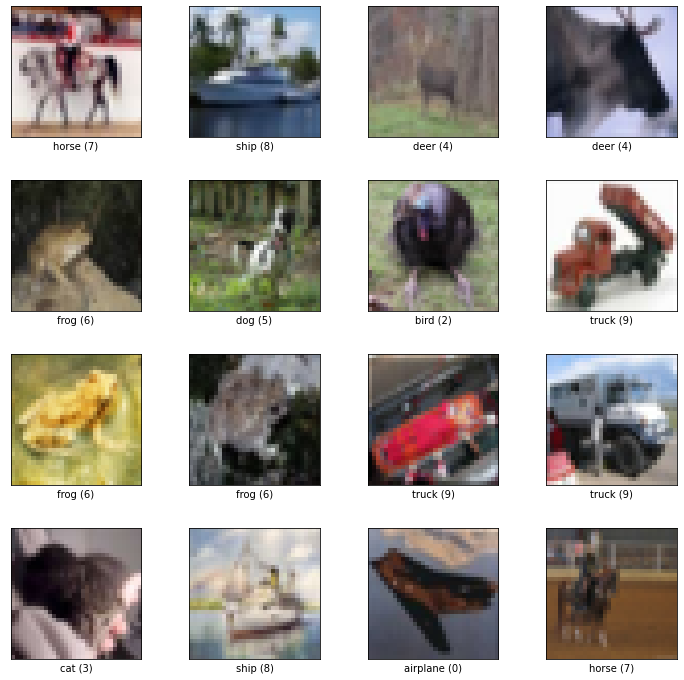

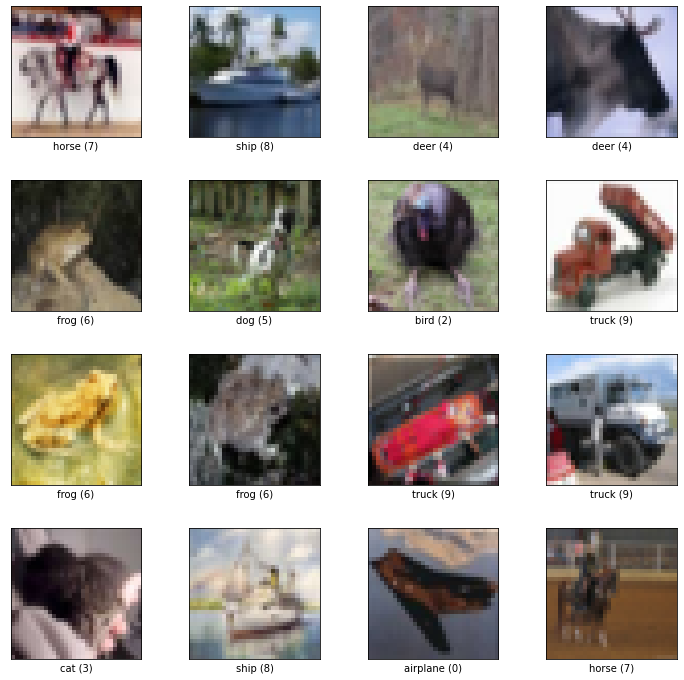

In [7]:
fg_sample = tfds.show_examples(dt_train, dt_info, rows = 4, cols = 4)
display(fg_sample)

In [8]:
#We can preprocess the data as ussual through the following procedure

In [9]:
def pre_proc_imgs(image, label):
  return tf.cast(image, tf.float32)/255.0,label


In [10]:
#The above data is already a tf.data type so no need to convert again
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
train_data = dt_train.map(pre_proc_imgs, num_parallel_calls = AUTOTUNE)#preprocess the images
train_data = train_data.cache()#to catche the train batch to make easy for the next iteration
train_data = train_data.shuffle(dt_info.splits['train'].num_examples)#to ensure randomness
train_data = train_data.batch(batch_size = BATCH_SIZE, drop_remainder = True) #splits into batches of size 64 (all of them)
train_data = train_data.prefetch(AUTOTUNE) #to prefetch the 64 images and make them ready for the next iteration (for GPU)
test_data = dt_test.map(pre_proc_imgs, num_parallel_calls = AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)
test_data = test_data.prefetch(AUTOTUNE)



In [59]:
#Building a quick simple model to train the data:

In [15]:
inputs = tf.keras.Input(shape = (32,32,3))
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(inputs)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam', metrics = ['accuracy'])
tic = time.time()
model.fit(train_data, validation_data = test_data, epochs = 10, verbose = 2)
display(model.summary())
toc = time.time()
print(f"time elapse: {time_fmt(toc - tic)}")

Epoch 1/10
390/390 - 10s - loss: 1.4462 - accuracy: 0.5083 - val_loss: 1.8585 - val_accuracy: 0.3548
Epoch 2/10
390/390 - 10s - loss: 0.9221 - accuracy: 0.6796 - val_loss: 1.2121 - val_accuracy: 0.5865
Epoch 3/10
390/390 - 8s - loss: 0.5436 - accuracy: 0.8140 - val_loss: 1.2566 - val_accuracy: 0.6096
Epoch 4/10
390/390 - 8s - loss: 0.2533 - accuracy: 0.9155 - val_loss: 1.4880 - val_accuracy: 0.6222
Epoch 5/10
390/390 - 8s - loss: 0.1149 - accuracy: 0.9630 - val_loss: 1.9785 - val_accuracy: 0.6104
Epoch 6/10
390/390 - 8s - loss: 0.0776 - accuracy: 0.9753 - val_loss: 2.2171 - val_accuracy: 0.6155
Epoch 7/10
390/390 - 8s - loss: 0.0724 - accuracy: 0.9762 - val_loss: 3.7889 - val_accuracy: 0.5393
Epoch 8/10
390/390 - 8s - loss: 0.0919 - accuracy: 0.9693 - val_loss: 2.7462 - val_accuracy: 0.5888
Epoch 9/10
390/390 - 8s - loss: 0.0937 - accuracy: 0.9697 - val_loss: 2.5147 - val_accuracy: 0.6097
Epoch 10/10
390/390 - 8s - loss: 0.0504 - accuracy: 0.9826 - val_loss: 3.0069 - val_accuracy: 0.60

None

time elapse: 0: 01: 22.00


In [17]:
#Loading and processing text data: Here we load and process imdb review dataset
#and build a simple predictive model to predict the sentiment status

In [18]:
(train_ds, test_ds), info_ds = tfds.load(
    name = 'imdb_reviews',
    split = ['train', 'test'],
    as_supervised = True,
    with_info = True,
    shuffle_files = True
)

print(info_ds)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHUBP47/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHUBP47/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHUBP47/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew

In [21]:
import sys
for text, label in train_ds:
  print(text)
  sys.exit()


tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [22]:
#We can tokenize and convert this texts into numerical indices:

In [32]:
tokenizer = tfds.deprecated.text.Tokenizer()
def voc_build():
  vocabulary = set()
  for text, _ in train_ds:
    vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
  return vocabulary


In [33]:
vocabulary = voc_build()